# Empirical Asset Pricing A 2021
## Homework 1: on classical puzzles of finance
**Xinyu Liu, INSEAD**

**08.01.2021**

## Overview

The Fama-French Portfolios are constructed from the intersections of two portfolios formed on size, as measured by **market equity (ME)**, and three portfolios using, as proxy for value, the **ratio of book equity to market equity (BE/ME)**. Portfolio returns are used to construct the Fama-French Factors.

## Preparation: Import packages and access data


In [2]:
###########################
# Fama French Data Grabber
###########################
#https://randlow.github.io/posts/finance-economics/pandas-datareader-KF/
#Please refer to this link if you have any further questions.

import pandas_datareader.data as web  # module for reading datasets directly from the web
#pip install pandas-datareader (in case you haven't install this package)
from pandas_datareader.famafrench import get_available_datasets
import pickleshare
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import datetime as dt
import psycopg2 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

#You can extract all the available datasets from Ken French's website and find that there are 297 of them. We can opt to see all the datasets available.
datasets = get_available_datasets()
print('No. of datasets:{}'.format(len(datasets)))
#datasets # comment out if you want to see all the datasets

No. of datasets:297


In [3]:
###########################
#Customize your data selection
###########################
#Note:If this is what you are intended to find: '6_Portfolios_ME_OP_2x3', but don't know exactly what it is named, do the following line
#df_me_op_factor = [dataset for dataset in datasets if 'ME' in dataset and 'OP' in dataset and '2x3' in dataset]
#print(df_me_op_factor)

#It is important to check the description of the dataset we access by using the following codes 
Datatoread='F-F_Research_Data_Factors'
sdate='1948-01-01'
edate='2017-12-31'
ds_factors = web.DataReader(Datatoread,'famafrench',start=sdate,end=edate) # Taking [0] as extracting 1F-F-Research_Data_Factors_2x3')
print('\nKEYS\n{}'.format(ds_factors.keys()))
print('DATASET DESCRIPTION \n {}'.format(ds_factors['DESCR']))
#From the printed information we know that we need to select the "0" name in the dictionary
#copy the right dict for later examination
dfFactor = ds_factors[1].copy()
dfFactor.reset_index(inplace=True)
# I check the scale of the data by printing out the head:
dfFactor.head()


KEYS
dict_keys([0, 1, 'DESCR'])
DATASET DESCRIPTION 
 F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202011 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (840 rows x 4 cols)
  1 : Annual Factors: January-December (70 rows x 4 cols)


,Date,Mkt-RF,SMB,HML,RF
0,1948,1.07,-9.14,3.52,0.81
1,1949,19.12,3.93,-4.55,1.10
2,1950,28.82,0.93,27.01,1.20
3,1951,19.22,-4.93,-5.93,1.49
4,1952,11.80,-6.66,3.34,1.66


In [4]:
#Date format adjustment
dfFactor['Date']=dfFactor['Date'].dt.year
dfFactor = dfFactor.set_index(['Date'])
# dfFactor['Date']=dfFactor['Date'].dt.to_timestamp(freq='M').dt.strftime('%Y-%m')
#Obtained object dtype
# dfFactor.index=pd.to_datetime(dfFactor.index)
#Obtained dt64, which is needed for the plotting 

In [6]:
# Access consumption data
import datapungibea as dpb
# https://pypi.org/project/datapungibea/
# Connect to Bureau of Economic Analysis (BEA) API
BEA_data = dpb.data('FDA2D756-CC0A-4AAA-A1D5-980FA23F31BB') #or data = dpb.data("API Key"), see setting up section   
#Basic package description
#BEA_data.datasetlist()
NIPA_cons=BEA_data.NIPA('T20302')
#Download annual consumption data on nondurable goods from Table 2.3.2. 
#on “Contributions to Percent Change in Real Personal Consumption Expenditures by Major Type of Product”
NIPA_cons.reset_index(inplace=True)
Consumption_data=NIPA_cons[NIPA_cons['LineDescription']=='-Nondurable goods']
Consumption_data = Consumption_data.T.iloc[4:,:]
Consumption_data.columns=['Consumption']

NIPA_inflation=BEA_data.NIPA('T10107')
NIPA_inflation.reset_index(inplace=True)
Inflation_data=NIPA_inflation[NIPA_inflation['LineDescription']=='--Nondurable goods']
Inflation_data = Inflation_data.T.iloc[4:,:]
Inflation_data.columns=['Inflation']

NIPA_data = pd.merge(Consumption_data,Inflation_data, how='inner', left_index= True, right_index=True)
NIPA_data=NIPA_data.astype(float)
NIPA_data.index=pd.to_datetime(NIPA_data.index)
NIPA_data=NIPA_data.resample('Y').mean()
year = NIPA_data.reset_index()['index'].dt.year
NIPA_data.loc[:,'Date']=year.values
NIPA_data = NIPA_data[(NIPA_data['Date']>=1948) & (NIPA_data['Date']<=2017)]
NIPA_data = NIPA_data.set_index('Date')

In [72]:
merged_data = dfFactor.merge(NIPA_data,how='left', left_index=True,right_index=True)
merged_data = merged_data.reset_index()
merged_data['Date'] = pd.to_datetime(merged_data['Date'],format='%Y')
merged_data = merged_data.set_index('Date')
merged_data['Mkt'] = merged_data['Mkt-RF'] + merged_data['RF'] 
merged_data['RF_adj'] = merged_data['RF'] - merged_data['Inflation'] 

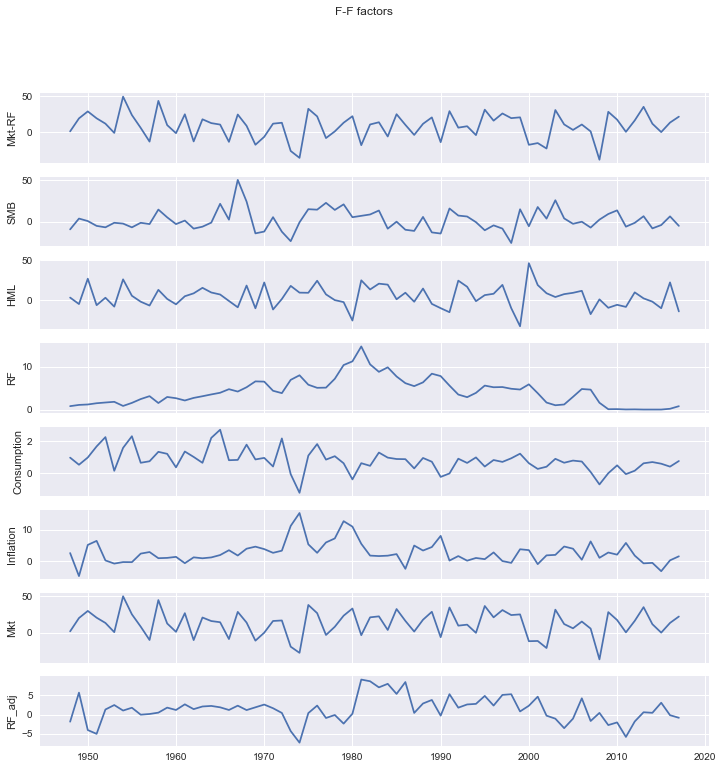

In [73]:
###########################
#Plot out the graphs
###########################
#See this link for detailed guidance on date ticks
# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html
# I am troubled by adjusting the format and making subplots for the whole evening and it turns out that things can be simplified in the following way:
years_fmt = mdates.DateFormatter('%Y')
#This will be used as input to adjust the axis label to be in the unit of year
n = len(merged_data.columns)
fig, axes = plt.subplots(n,1,figsize=(12,12),sharex=True)
#Using sharex help making the plot simple and easy to read
# Create fig and axes class so I can then process with them in the for loop.
fig.suptitle('F-F factors')
for k,factortitle in enumerate(merged_data.columns):
    ax = axes[k]
    ax.plot(merged_data.index,merged_data[[factortitle]])
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(factortitle)
plt.show()

In [60]:
#I take log transformation of the returns to fit the setting of theory
merged_data = np.log(merged_data/100+1)*100
#Calculate summary statistics 
summary_stats = pd.DataFrame()
summary_stats.loc[0,'average market excess return'] = merged_data['Mkt-RF'].mean()*0.01
summary_stats.loc[0,'average risk-free rate'] = (merged_data['RF'].mean()-merged_data['Inflation'].mean())*0.01
summary_stats.loc[0,'volatility of market return'] = merged_data['Mkt'].std()*0.01
summary_stats.loc[0,'volatility of market excess return'] = merged_data['Mkt-RF'].std()*0.01
summary_stats.loc[0,'volatility of consumption growth'] = merged_data['Consumption'].std()*0.01
summary_stats.loc[0,'covariance of market and consumption'] = merged_data[['Consumption','Mkt']].cov().iloc[0,1]*0.0001

#Make latex table
print(summary_stats.to_latex(index=False))

In [71]:
# Define a funtion to calculate the risk aversion coefficient
def risk_aversion(Er_Mkt, rf, Var_r, covariance):
    gamma = (Er_Mkt - rf + Var_r/2)/(covariance)
    return gamma 

risk_aversion(summary_stats.loc[0,'average market excess return'],summary_stats.loc[0,'average risk-free rate'],summary_stats.loc[0,'volatility of market excess return']**2,summary_stats.loc[0,'covariance of market and consumption'])

151.3042929908286

## Procedure

In [ ]:
Equity Premium Puzzle